In [1]:
pip install azure-storage-blob opencv-python pandas pillow torch torchvision scikit-learn matplotlib

  Using cached azure_storage_blob-12.25.1-py3-none-any.whl.metadata (26 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl.metadata (19 kB)
  Using cached pillow-11.2.1-cp39-cp39-win_amd64.whl.metadata (9.1 kB)
  Using cached torch-2.7.0-cp39-cp39-win_amd64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp39-cp39-win_amd64.whl.metadata (6.3 kB)
  Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl.metadata (15 kB)
  Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached azure_core-1.34.0-py3-none-any.whl.metadata (42 kB)
  Using cached cryptography-45.0.3-cp37-abi3-win_amd64.whl.metadata (5.7 kB)
  Using cached isodate-0.7.2-py3-none-any.whl.metadata (11 kB)
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Us

In [2]:
# loads our needed packages
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
from torchvision.models import resnet18
import numpy as np
from sklearn.cluster import KMeans

In [3]:
# loads our csv that has the merged bounding box data
csv_path = 'combined_defects.csv'
df = pd.read_csv(csv_path)

# sets image folder path
image_folder = 'Images'

# loads image by image id
def load_image(image_id, ext='.png'):
    image_path = os.path.join(image_folder, f"{image_id}{ext}")
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    return Image.open(image_path).convert('RGB')

# crops defect region to that stated in the bounding box
def crop_defects(df):
    crops = []
    for idx, row in df.iterrows():
        image_id = row['image_id']
        x, y, w, h = int(row['BX']), int(row['BY']), int(row['Width']), int(row['Height'])
        
        try:
            img = load_image(image_id)  # Load the full image
            crop = img.crop((x, y, x + w, y + h))  # Crop box: (left, upper, right, lower)
            crops.append({
                'image_id': image_id,
                'bbox': (x, y, w, h),
                'crop': crop
            })
        except Exception as e:
            print(f"Skipping defect at index {idx} in image '{image_id}': {e}")
    
    return crops

# executes cropping
cropped_defects = crop_defects(df)
print(f"Cropped {len(cropped_defects)} defect regions.")

# # save cropped images to disk to double check the crop was correct
# output_folder = 'defect_crops'
# os.makedirs(output_folder, exist_ok=True)

# for i, item in enumerate(cropped_defects):
#     filename = f"{item['image_id']}_defect_{i}.png"
#     path = os.path.join(output_folder, filename)
#     item['crop'].save(path)


Cropped 743 defect regions.


In [4]:
# model set up pre-trained ResNet18, remove final classification layer
model = resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # remove last fc layer
model.eval()  # inference mode

# image pre processing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])    # ImageNet stds
])

# gets embedding from crop
def get_embedding(crop_img):
    input_tensor = preprocess(crop_img).unsqueeze(0)  # add batch dim
    with torch.no_grad():
        features = model(input_tensor)
    features = features.squeeze().numpy()  # shape (512,)
    return features

# applies to all cropped regions
features_list = []
for item in cropped_defects:
    crop_img = item['crop']
    emb = get_embedding(crop_img)
    features_list.append({
        'image_id': item['image_id'],
        'bbox': item['bbox'],
        'embedding': emb
    })

print(f"Extracted embeddings for {len(features_list)} defects.")

X = np.array([item['embedding'] for item in features_list])


c:\Users\final\Documents\CHEM_543_SQ25\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\final\Documents\CHEM_543_SQ25\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracted embeddings for 743 defects.


In [5]:
# set number of clusters for KMeans
n_clusters = 5

# initialize and fit KMeans
kmeans = KMeans(n_clusters = n_clusters, 
                random_state = 42)
kmeans.fit(X)

# gets cluster labels for each defect
labels = kmeans.labels_

# adds cluster labels back to features_list
for i, item in enumerate(features_list):
    item['cluster'] = labels[i]

# prints how many defects per cluster
from collections import Counter
print("Defect counts per cluster:")
print(Counter(labels))

Defect counts per cluster:
Counter({np.int32(1): 228, np.int32(0): 183, np.int32(4): 155, np.int32(3): 136, np.int32(2): 41})


In [54]:
# # saves data to a new csv
# output_rows = []
# for item in features_list:
#     image_id = item['image_id']
#     bx, by, w, h = item['bbox']
#     cluster = item['cluster']
#     output_rows.append({
#         'image_id': image_id,
#         'BX': bx,
#         'BY': by,
#         'Width': w,
#         'Height': h,
#         'Cluster': cluster
#     })

# df_out = pd.DataFrame(output_rows)
# df_out.to_csv('defects_clustered.csv', index=False)
# print("Saved clustering results to defects_clustered.csv")

Text(0, 0.5, 'Frequency')

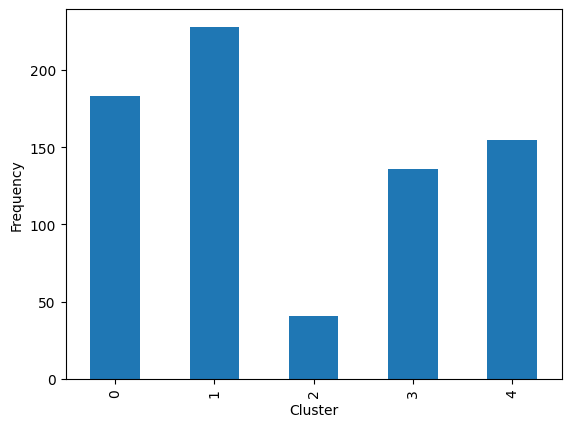

In [6]:
# converts features_list into a dataframe for plotting
df = pd.DataFrame(features_list)
df = df.drop(df.columns[1:3],
             axis = 1)


graph = df['cluster'].value_counts().sort_index()
graph.plot(kind = 'bar')
plt.xlabel("Cluster")
plt.ylabel("Frequency")

In [ ]:
# replots bounding boxes using new clusters
# paths
image_folder = 'Images'
output_folder = 'clustered_images_c5'
os.makedirs(output_folder, exist_ok=True)

# cluster colors (sequentially used)
cluster_colors = [
    'white', 'blue', 'green', 'orange', 'black',
    'black', 'cyan', 'lime', 'purple', 'gray'
]

# groups defects by image
from collections import defaultdict
defects_by_image = defaultdict(list)
for item in features_list:
    defects_by_image[item['image_id']].append(item)

# draws bounding boxes with cluster colors on each image
for image_id, defects in defects_by_image.items():
    img_path = os.path.join(image_folder, f"{image_id}.png")
    if not os.path.exists(img_path):
        print(f"Image not found for visualization: {img_path}")
        continue
    
    img = Image.open(img_path).convert('RGB')
    draw = ImageDraw.Draw(img)

    for defect in defects:
        bx, by, w, h = defect['bbox']
        cluster = defect['cluster']
        color = cluster_colors[cluster % len(cluster_colors)]
        draw.rectangle([bx, by, bx + w, by + h], outline=color, width=3)
    
    # saves images
    out_path = os.path.join(output_folder, f"{image_id}_clustered.png")
    img.save(out_path)
    print(f"Saved clustered image: {out_path}")

Saved clustered image: clustered_images_c5\1_clustered.png
Saved clustered image: clustered_images_c5\10_clustered.png
Saved clustered image: clustered_images_c5\11_clustered.png
Saved clustered image: clustered_images_c5\12_clustered.png
Saved clustered image: clustered_images_c5\13_clustered.png
Saved clustered image: clustered_images_c5\14_clustered.png
Saved clustered image: clustered_images_c5\15_clustered.png
Saved clustered image: clustered_images_c5\16_clustered.png
Saved clustered image: clustered_images_c5\17_clustered.png
Saved clustered image: clustered_images_c5\18_clustered.png
Saved clustered image: clustered_images_c5\19_clustered.png
Saved clustered image: clustered_images_c5\2_clustered.png
Saved clustered image: clustered_images_c5\20_clustered.png
Saved clustered image: clustered_images_c5\21_clustered.png
Saved clustered image: clustered_images_c5\22_clustered.png
Saved clustered image: clustered_images_c5\23_clustered.png
Saved clustered image: clustered_images_c5